In [1]:
import glob
import string

import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams

from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelWithLMHead, pipeline

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# read_csv
df = pd.read_csv("Customer_Survey_Result_May_2022.csv", skiprows=[1]).fillna('')
df.head()

,SurveyType,Respondent ID,Collector ID,Start Date,End Date,IP Address,Email Address,First Name,Last Name,Custom Data 1,Which of the following best describes your roles?,How likely would you recommend our AsiaPac Services to a friend or colleague?,What are the primary reasons for the score you gave us?,Would you agree that our service is convenient to access?,How would you rate your experience with our service desk?,How would you rate our service desk follow up and communication skill?,How would you rate the proactiveness of our engineers?,How would you rate the competency of our engineers to resolve your issue?,How would you rate the friendliness of our engineers?,How can we make your experience better?
0,General,1.180000e+11,445889390,5/26/2022 15:15,5/26/2022 15:18,129.126.34.65,thor_ya_lin@moe.edu.sg,Ya Lin,Thor,,IT,4,Depends on the responsiveness of service.,4,3,3,3,3,3,Be more responsible to notify when there are c...
1,General,1.180000e+11,445889390,5/26/2022 10:45,5/26/2022 10:46,138.75.213.220,jiawei@sphreit.com.sg,Chow,Jia Wei,,End User,8,,5-Very Positive,4,4,5-Very Positive,5-Very Positive,5-Very Positive,
2,General,1.180000e+11,445889390,5/26/2022 10:21,5/26/2022 10:24,119.74.202.86,lygoo@primeusreit.com,Goo,Liang Yin,,Manager,5,AsiaPac requires one-year's charges to be paid...,3,3,3,3,3,4,AsiaPac has been slow in preparing documentati...
3,General,1.180000e+11,445889390,5/26/2022 9:20,5/26/2022 9:23,140.82.203.136,darren@spnoble.com.sg,Darren,Kong,,IT,10-Most Likely,Price and service,4,4,4,4,4,4,non
4,General,1.180000e+11,445889390,5/26/2022 9:16,5/26/2022 9:18,129.126.34.27,oh_chee_wee@moe.edu.sg,Chee Wee,Oh,,IT,7,Follow up updates can be more prompt. Better ...,3,4,3,3,3,3,Need more experience with technical support


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 20 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   SurveyType                                                                     130 non-null    object 
 1   Respondent ID                                                                  130 non-null    float64
 2   Collector ID                                                                   130 non-null    int64  
 3   Start Date                                                                     130 non-null    object 
 4   End Date                                                                       130 non-null    object 
 5   IP Address                                                                     130 non-null    object 
 6   Email Address             

In [4]:
roles = df['Which of the following best describes your roles?'].unique()

In [5]:
services = [i for i in df.SurveyType.unique()]

In [6]:
respondants = {}
for s in services:
    respondants[s] = {}
    df_ = df[df.SurveyType == s]
    for r in roles:
        respondants[s][r] = len(df_[df_['Which of the following best describes your roles?'] == r])
        
df_resp = pd.DataFrame(respondants)
df_resp

,General,EUC,APS,AMS,Cloud
IT,18,3,3,6,3
End User,12,9,5,5,6
Manager,14,8,9,7,7
C-Level,2,1,0,0,1
VP / Director,0,3,3,2,3


Text(0.5, 1.0, 'distribution of the respondants')

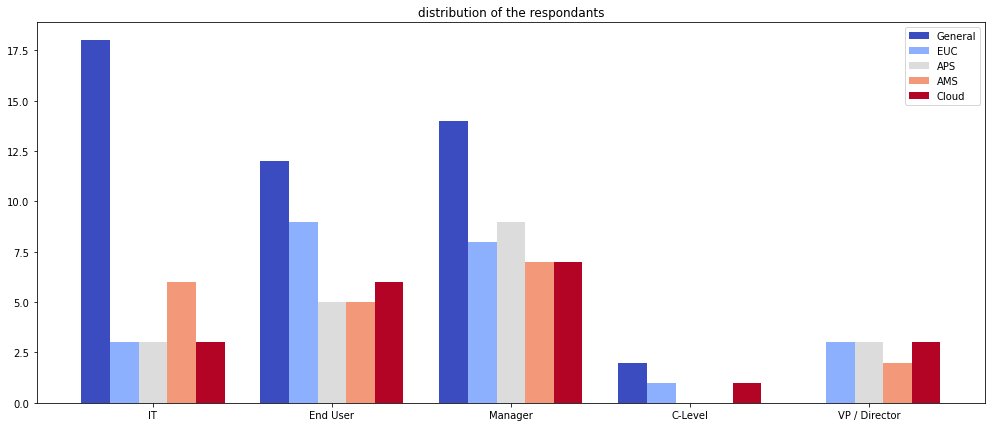

In [7]:
rcParams['figure.figsize'] = 17, 7
df_resp.plot(kind='bar', colormap=cm.coolwarm, width=.8)
plt.xticks(rotation=0)
plt.title('distribution of the respondants')

As we can see from the .info() above, we have 130 entries in our raw data issues from the questionnaire, the next step will consist on computing the **NPS**, **CSAT** and **CET** matricies

## NPS

In [8]:
NPS = {}
# NPS matrix involes ony the columns 
# starting with "How likely would you recommend our"

promoters = 0
detractors = 0
total_n = 0

c = "How likely would you recommend our AsiaPac Services to a friend or colleague?"
for s in services:
    col = df[df.SurveyType == s][c]
    col = col.astype('str').str.extractall('(\d+)').astype('int').unstack().sum(axis=1).astype(int)
    n = len(col)
    total_n = total_n + n
    promoters = promoters + len(col[col>8])
    detractors = detractors + len(col[col<7])
    nps = (len(col[col>8]) - len(col[col<7])) / n
    NPS[s] = round(nps * 100, 3)


In [9]:
print('Promoters = ', promoters, promoters/total_n*100)
print('Detractors = ', detractors, detractors/total_n*100)
print('Passives = ', total_n - (promoters + detractors), total_n - (promoters + detractors)/total_n*100)
print('Overall NPS =', ((promoters - detractors) / total_n))

Promoters =  48 36.92307692307693
Detractors =  44 33.84615384615385
Passives =  38 59.230769230769226
Overall NPS = 0.03076923076923077


In [10]:
data =[["Service", 'NPS']] + list(NPS.items())
table = tabulate.tabulate(data, tablefmt='html')
table

Service,NPS
General,0.0
EUC,4.167
APS,-10.0
AMS,5.0
Cloud,20.0


the NPS is good for all the services but the APS (-10%) which can drive less customer retention for that specific service

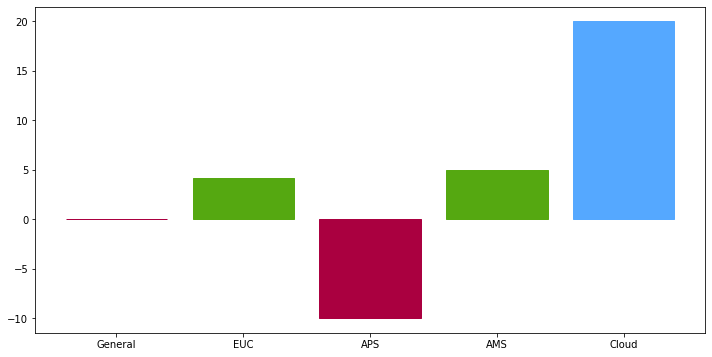

In [11]:
fig, ax = plt.subplots(figsize=(12,6))

N = ax.bar(NPS.keys(), NPS.values(), edgecolor='black', linewidth=1)
for rect in ax.patches:
    if 0 < rect.get_height() <= 10:
        rect.set_color('#55a811')
    elif  10 <= rect.get_height() :
        rect.set_color('#55a8ff')
    else:
        rect.set_color('#aa0040')


## CSAT

In [12]:
CSAT = {}
delights = 0
satisfies = 0
almost = 0
disappoints_2 = 0
disappoints_1 = 0
for s in services:
    CSAT[s] = {}
    df_ = df[df.SurveyType == s]
    for c in df.columns:
        if 'rate' in c: 
            cc = c[23:].replace('?', '')
            if 'of' in cc: cc = cc[:cc.find('of')+2] + ' \n ' + cc[cc.find('of')+2:]
            elif "up" in cc: cc = cc[:cc.find('up')] + ' \n ' + cc[cc.find('up'):]

            col = df_[c].dropna()
            col = col.astype('str').str.extractall('(\d+)').astype('int').unstack().sum(axis=1).astype(int)
            n = len(col)
            
            delights = delights + len(col[col==5])
            satisfies = satisfies + len(col[col==4])
            almost = almost + len(col[col==3])
            disappoints_2 = disappoints_2 + len(col[col==2])
            disappoints_1 = disappoints_1 + len(col[col==1])
            
            csat = len(col[col>3]) / n
            CSAT[s][cc] = round(csat * 100, 3)


In [13]:
tot = delights+satisfies+almost+disappoints_2+disappoints_1
print('delights = ',delights, delights/tot*100)
print('satisfies = ',satisfies, satisfies/tot*100)
print('almost = ',almost, almost/tot*100)
print('disappoints = ',disappoints_2+disappoints_1 , (disappoints_2+disappoints_1)/tot*100)
print(((delights*5)+(satisfies*4)+(almost*3)+(disappoints_2*2)+(disappoints_1*1))/(tot*5)*100)

delights =  160 24.615384615384617
satisfies =  202 31.076923076923073
almost =  217 33.38461538461539
disappoints =  71 10.923076923076923
73.50769230769231


In [14]:
df_csat = pd.DataFrame(CSAT)
df_csat.corr()

,General,EUC,APS,AMS,Cloud
General,1.000000,0.661729,0.739933,0.537070,0.468793
EUC,0.661729,1.000000,0.985451,0.945403,0.958315
APS,0.739933,0.985451,1.000000,0.939336,0.922410
AMS,0.537070,0.945403,0.939336,1.000000,0.981981
Cloud,0.468793,0.958315,0.922410,0.981981,1.000000


In [15]:
df_csat

,General,EUC,APS,AMS,Cloud
experience with our service desk,54.348,37.500,40.0,45.0,55.0
service desk follow \n up and communication skill,52.174,33.333,40.0,50.0,55.0
proactiveness of \n our engineers,50.000,50.000,50.0,65.0,70.0
competency of \n our engineers to resolve your issue,54.348,58.333,60.0,65.0,70.0
friendliness of \n our engineers,63.043,66.667,70.0,75.0,75.0


Text(0.5, 1.0, 'CSAT scores across services')

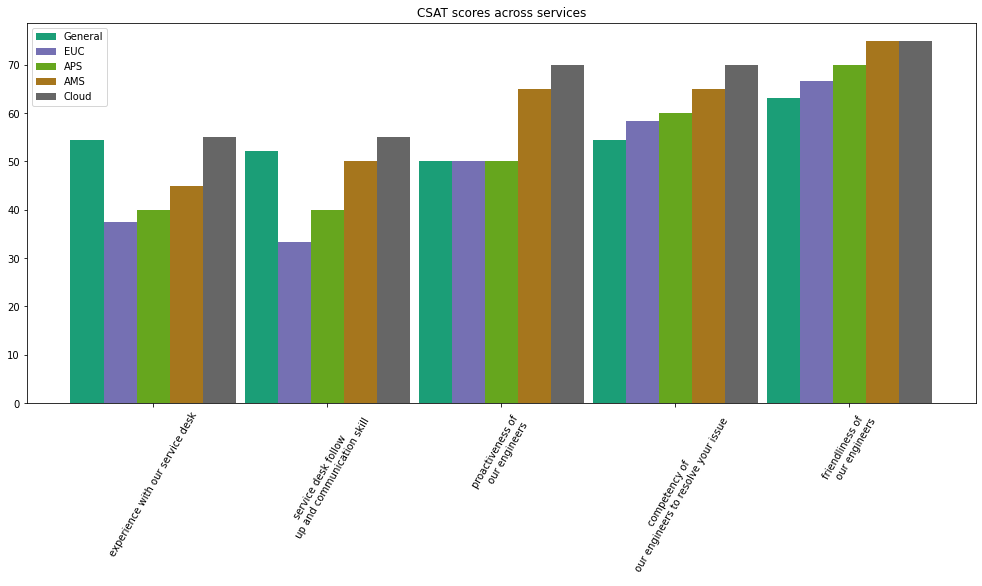

In [16]:
rcParams['figure.figsize'] = 17, 7
df_csat.plot(kind='bar', colormap=cm.Dark2, width=.95)
plt.xticks(rotation = 60) 
plt.title('CSAT scores across services')

This table summarise the the custumer satisfaction score for exemple: 
- friendliness of our engineers, Cloud  -> 75

Translates to 75% of Cloud costumers are satisfied with the friendliness of the engineers

## CET

In [17]:
CET = {}
delights = 0
satisfies = 0
almost = 0
disappoints_2 = 0
disappoints_1 = 0
for s in services:
    df_ = df[df.SurveyType == s]
    cc = 'service is convenient to access'
    col = df_["Would you agree that our service is convenient to access?"].dropna()
    col = col.astype('str').str.extractall('(\d+)').astype('int').unstack().sum(axis=1).astype(int)
    n = len(col)
    
    delights = delights + len(col[col==5])
    satisfies = satisfies + len(col[col==4])
    almost = almost + len(col[col==3])
    disappoints_2 = disappoints_2 + len(col[col==2])
    disappoints_1 = disappoints_1 + len(col[col==1])

    cet = len(col[col>3]) / n
    CET[s] = round(cet * 100, 2)

In [18]:
tot = delights+satisfies+almost+disappoints_2+disappoints_1
print('total = ',tot)
print('delights = ',delights, delights/tot*100)
print('satisfies = ',satisfies, satisfies/tot*100)
print('almost = ',almost, almost/tot*100)
print('disappoints = ',disappoints_2+disappoints_1 , (disappoints_2+disappoints_1)/tot*100)
print(((delights*5)+(satisfies*4)+(almost*3)+(disappoints_2*2)+(disappoints_1*1))/(tot*5)*100)

total =  130
delights =  33 25.384615384615383
satisfies =  46 35.38461538461539
almost =  48 36.92307692307693
disappoints =  3 2.307692307692308
76.76923076923077


In [19]:
df_cet = pd.DataFrame([CET], index={'CET'})
df_cet

,General,EUC,APS,AMS,Cloud
CET,65.22,54.17,60.0,55.0,65.0


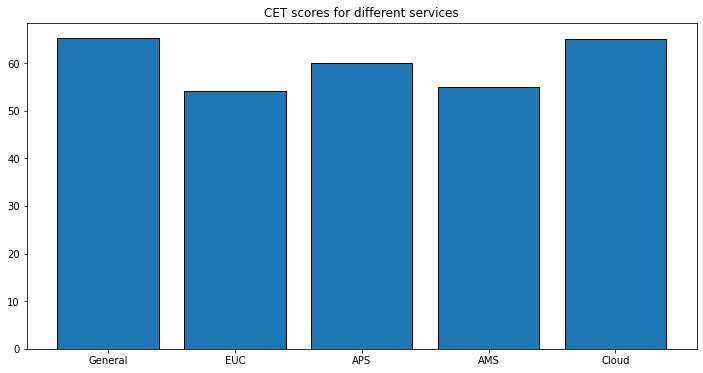

In [20]:
fig, ax = plt.subplots(figsize=(12,6))

N = ax.bar(CET.keys(), CET.values(), edgecolor='black', linewidth=1)
plt.title('CET scores for different services')
plt.show()

In [21]:
df_corr = pd.concat([df_cet, pd.DataFrame([NPS], index={'NPS'}), df_csat])
df_corr

,General,EUC,APS,AMS,Cloud
CET,65.220,54.170,60.0,55.0,65.0
NPS,0.000,4.167,-10.0,5.0,20.0
experience with our service desk,54.348,37.500,40.0,45.0,55.0
service desk follow \n up and communication skill,52.174,33.333,40.0,50.0,55.0
proactiveness of \n our engineers,50.000,50.000,50.0,65.0,70.0
competency of \n our engineers to resolve your issue,54.348,58.333,60.0,65.0,70.0
friendliness of \n our engineers,63.043,66.667,70.0,75.0,75.0


In [22]:
corr = df_corr.corr()
corr

,General,EUC,APS,AMS,Cloud
General,1.000000,0.887087,0.952702,0.894842,0.917483
EUC,0.887087,1.000000,0.983393,0.964293,0.974014
APS,0.952702,0.983393,1.000000,0.969712,0.980747
AMS,0.894842,0.964293,0.969712,1.000000,0.992924
Cloud,0.917483,0.974014,0.980747,0.992924,1.000000


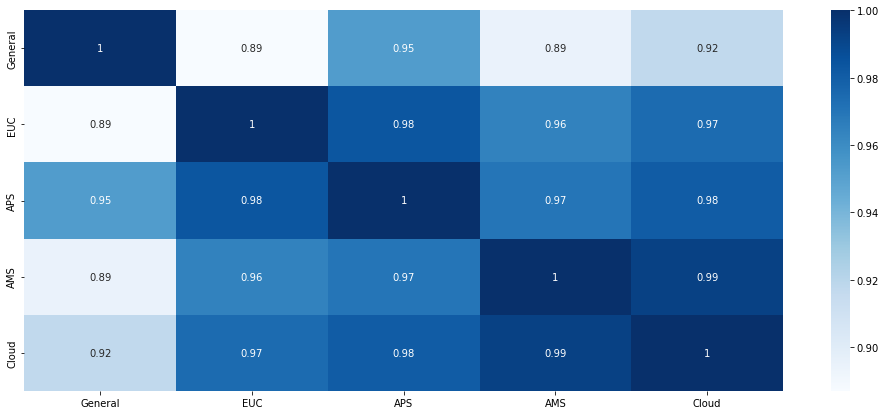

In [23]:
import seaborn as sb

sb.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [24]:
corr = df_corr.T.corr()
corr

,CET,NPS,experience with our service desk,service desk follow \n up and communication skill,proactiveness of \n our engineers,competency of \n our engineers to resolve your issue,friendliness of \n our engineers
CET,1.000000,0.232342,0.844451,0.683119,0.142413,0.047977,-0.153362
NPS,0.232342,1.000000,0.552107,0.520646,0.807444,0.716157,0.495286
experience with our service desk,0.844451,0.552107,1.000000,0.927867,0.484474,0.250968,0.061494
service desk follow \n up and communication skill,0.683119,0.520646,0.927867,1.000000,0.666185,0.430986,0.337472
proactiveness of \n our engineers,0.142413,0.807444,0.484474,0.666185,1.000000,0.933121,0.867889
competency of \n our engineers to resolve your issue,0.047977,0.716157,0.250968,0.430986,0.933121,1.000000,0.945445
friendliness of \n our engineers,-0.153362,0.495286,0.061494,0.337472,0.867889,0.945445,1.000000


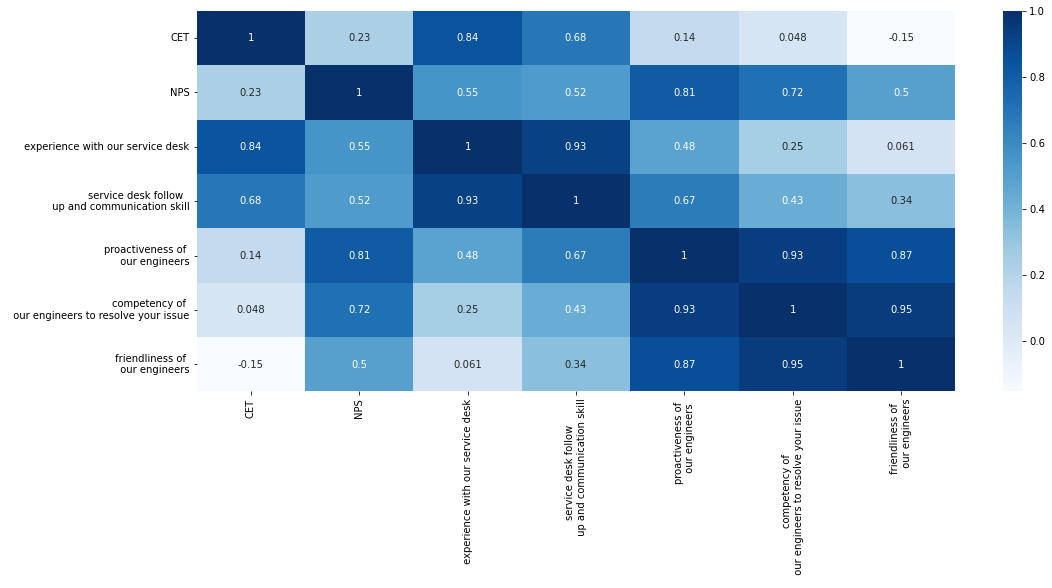

In [25]:
sb.heatmap(corr, cmap="Blues", annot=True)
plt.show()

Lastly the Costumer Effort Score (SET) measure the level of effort that a customer experienced with a particular
interaction in our case "convenient to access to the Cloud service" 65.0% find it convenient.

In [26]:
df['How can we make your experience better?'][2]

'AsiaPac has been slow in preparing documentation/agreements for renewal and also slow in addressing queries raised by our Compliance person.  Needs to be more timely.'

## Sentiment analysis

In [27]:
# Allocate a pipeline for sentiment-analysis
model_sentan = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

def get_sentiment(text):
    return model_sentan(text[:512])[0]['label']

df['sentiment'] = df['How can we make your experience better?'].apply(get_sentiment)
df['sentiment'] = df['sentiment'].map({"NEU":'Neutral', "POS":"Positive", "NEG":"Negative"})

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

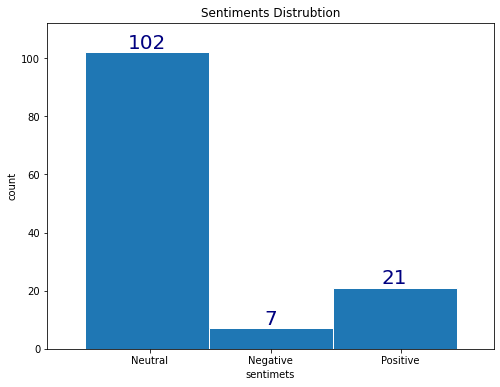

In [28]:
plt.figure(figsize=(8, 6))
values, bins, bars = plt.hist(df['sentiment'], bins=3, linewidth=1, edgecolor='white')
plt.ylabel('count')
plt.xlabel('sentimets');
plt.title('Sentiments Distrubtion')
plt.bar_label(bars, fontsize=20, color='navy')
plt.xticks([0.35, 1, 1.7], ['Neutral','Negative','Positive'])
plt.margins(x=0.1, y=0.1)
plt.show()

In [29]:
df[~df['How can we make your experience better?'].isin(['', 'NIL', '-'])][['How can we make your experience better?', 'sentiment']].sample(15, random_state=1)

,How can we make your experience better?,sentiment
50,I seldom talk to engineers or service desk ppl...,Neutral
58,Service level,Neutral
38,Great customer service and professional engine...,Positive
53,It would be better if the Service Desk is able...,Negative
47,Conduct random survey after every ticket closure.,Neutral
119,Netrual. Have not really engaged with the team.,Neutral
79,To improve skill and communication,Positive
98,Better client engagement.,Positive
126,Proactiveness,Positive
77,Netrual. Have not really engaged with the team.,Neutral


The model shows all 3 different type of sentiment 'Positive', 'Negative' and 'neutral'

## Emotion detection 

In [30]:
model_emdet = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=False)

def get_emotion(text):
    return model_emdet(text)[0]["label"]

For the Emotion detection part we will try base our prediction on the subjectivity of the input first then assign the correspondant emotion

In [31]:
polarity, subjectivity, emotions = [], [], []
for i in range(len(df)):
    text = df.loc[i]['How can we make your experience better?']
    sent = TextBlob(df.loc[i]['How can we make your experience better?']).sentiment
    polarity.append(sent.polarity)
    subjectivity.append(sent.subjectivity)
    if sent.subjectivity > 0:
        text = df.loc[i]['How can we make your experience better?'][:512]
        emotions.append(get_emotion(text))
    else:
        emotions.append('-')
df['polarity'] = polarity
df['subjectivity'] = subjectivity
df['emotion'] = emotions

In [32]:
x = df[df['emotion'] != '-']['emotion'].values

As we are working with only the subjectve sentences we are left with 27 sentence out of 84 entries (including the empty responses)

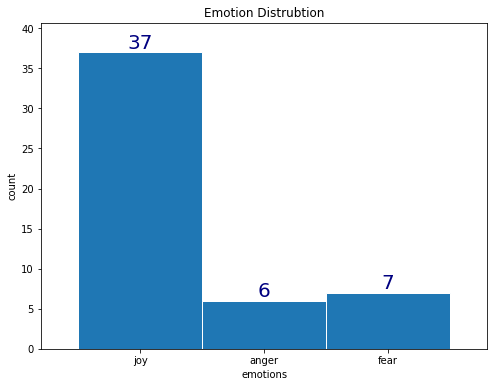

In [33]:
plt.figure(figsize=(8, 6))
values, bins, bars = plt.hist(x, bins=3, linewidth=1, edgecolor='white')
plt.ylabel('count')
plt.xlabel('emotions');
plt.title('Emotion Distrubtion')
plt.bar_label(bars, fontsize=20, color='navy')
plt.xticks([0.5, 1.5, 2.5], ['joy','anger','fear'])
plt.margins(x=0.1, y=0.1)
plt.show()

## More Emotion

In [34]:
data = df['How can we make your experience better?']

In [35]:
import re
# excluding ponctuation from the sentnence
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

# split sentence to tokens
def tokenization(text):
    tokens = text.split(' ')
    return tokens
import nltk

#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english') + ['nil']
#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output = [i for i in text if i not in stopwords]
    return output

In [36]:
# apply all the processing functions
data = data.apply(lambda x:remove_punctuation(x))\
            .apply(lambda x:x.lower())\
            .apply(lambda x: tokenization(x))\
            .apply(lambda x: remove_stopwords(x))

In [37]:
# build a giant corpus for the wordcloud
text = ''
for i in range(len(data)):
    if data[i] != []:
        text += ' ' + ' '.join(data[i])

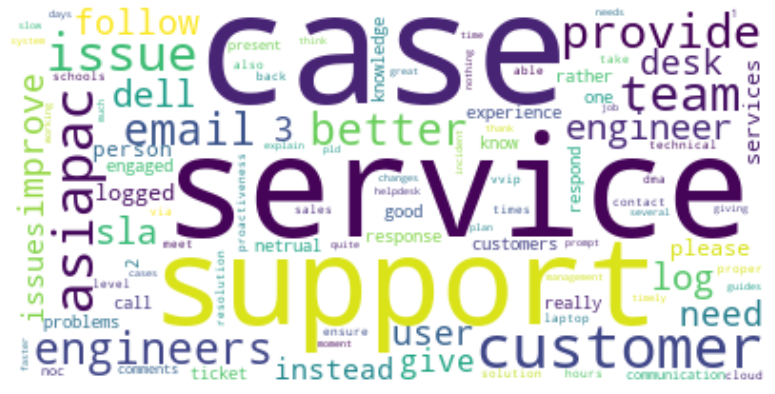

In [38]:
import multidict as multidict

import numpy as np

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def makeImage(text):

    wc = WordCloud(background_color="white", max_words=100, )
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()


makeImage(getFrequencyDictForText(text))

For this part we will try to do some kind of clustering/topic modeling using *tf-idf* to try group our data point 

In [39]:
data = data.apply(lambda x: ' '.join(x))
data = data[data != '']

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import numpy as np

vectorizer = TfidfVectorizer(max_features=1000) 
X = vectorizer.fit_transform(data)

In [41]:
distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

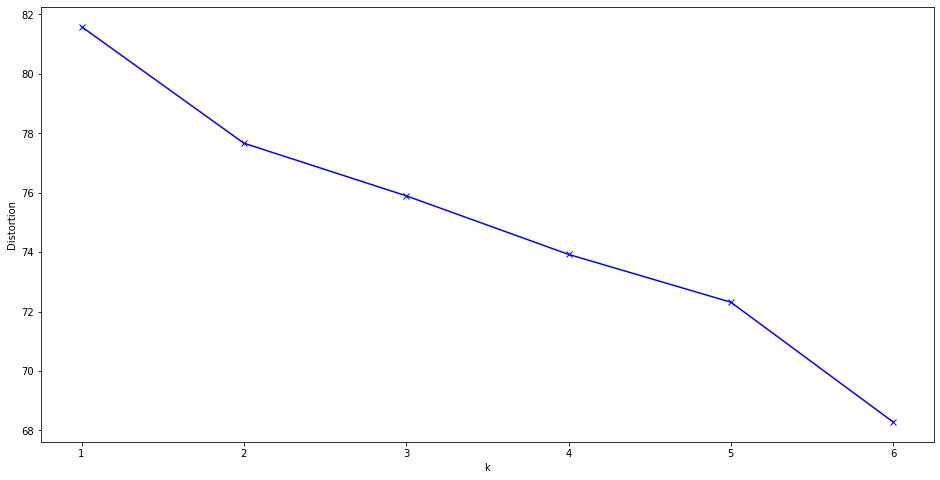

In [42]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

as we can see the `k=3` is a proper choice for the K-means algorithm and it is reflected in the data as 3 emotions are present in the data


## Thematic analysis

In [43]:
folder = "Thematic Data/*.csv"

files = glob.glob(folder)
files

['Thematic Data\\ServiceRequest_Data_May_2022.csv',
 'Thematic Data\\SLA_Data_May_2022.csv',
 'Thematic Data\\Tickets_Data_May_2022.csv',
 'Thematic Data\\Worklog_Data_May_2022.csv']

As for this part we will use only the `Tickets_Data_May_2022.csv`, `ServiceRequest_Data_May_2022.csv` and `Worklog_Data_May_2022.csv` as they contain text data

In [44]:
print(files[0])
df1 = pd.read_csv(files[0], encoding_errors='ignore').drop_duplicates()
df2 = pd.read_csv(files[2], encoding_errors='ignore').drop_duplicates()
df3 = pd.read_csv(files[-1], encoding_errors='ignore').drop_duplicates()

Thematic Data\ServiceRequest_Data_May_2022.csv


C:\Users\kelvin.liew\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (21,31,32,42,44,82,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [45]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
porter = PorterStemmer()

import re, string
import numpy as np
from collections import defaultdict, Counter
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import json
import operator
from operator import itemgetter

from pylab import rcParams
rcParams['figure.figsize'] = 17, 7

np.random.seed(2)

In [46]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kelvin.liew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kelvin.liew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kelvin.liew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
t1 = df1["Summary*"].tolist()
t2 = (df2['Description ']+df2.Resolution.apply(lambda x: " "+str(x))).tolist()
t3 = df3["Work Log Description"].tolist()
T = list(map(str, t1+t2+t3))

In [48]:
Text = pd.Series(T, dtype=str)

In [49]:
Text

0         [REQ000000055868] SOFTWARE REQUEST : OnePlace ...
1         [REQ000000056114] SOFTWARE REQUEST : OnePlace ...
2         [REQ000000055867] MEETING ROOM SETUP REQUEST: ...
3         [REQ000000055866] Request Reset Authenticators...
4         [WO0000000026146] Onboard New Server Build NTP...
                                ...                        
225404    From: gm.lim@kslmaritime.com.sg \nTo: serviced...
225405    Assigned To: ShimYV by Remedy Application Service
225406                 Status Marked: In Progress by zoeann
225407    From: wong.sueying@paxocean.com \nTo: serviced...
225408     Assigned To: lawfw by Remedy Application Service
Length: 225409, dtype: object

In [50]:
# get stopwords list
stoplist = stopwords.words('english')
# get list of punctuations
punctuations = string.punctuation + "’¶•@°©®™"

In [51]:
def preprocess_text(text):
    """
    @param text string
    @return text string
    
    This function preprocess a given raw text by normalizing it to lowercase removing the stop words,
    punctuations and lemmatization
    """
        
    #string to lowercase
    txt = text.lower()
    
    # keep only ascii characters
    txt = re.sub("\[[REQ]*\d+\]\ *", "", txt)
    txt = re.sub(r"[^a-zA-ZÀ-ÿ]", " ", txt)
    
    #punctuation removal and map it to space
    translator = str.maketrans(punctuations, " "*len(punctuations))
    s = txt.translate(translator)
    
    #remove digits 
    no_digits = ''.join([i for i in s if not i.isdigit()])
    cleaner = " ".join(no_digits.split())
    
    # tokenize words and removing stop words 
    word_tokens = word_tokenize(cleaner)
    filtered_sentence = [w for w in word_tokens if not w in stoplist+['req', 'mailto', 'kuokgroup', 'com']]
    filtered_sentence = [w for w in filtered_sentence if len(w)>2 ]
    filtered_sentence = " ".join(filtered_sentence)
    
    # a double layer lemmatization word block
    filtered_sentence = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(filtered_sentence)])
    
    return filtered_sentence

In [52]:
example = Text[7]
print("Text before preprocessing : \n {}\n".format(example))
clean = preprocess_text(example)
print("Text After preprocessing : \n {}".format(clean))

Text before preprocessing : 
 [WO0000000026143] Request COMPAS- NON COMPLIANCE TAB

Text After preprocessing : 
 request compas non compliance tab


In [53]:
Text = Text.apply(preprocess_text)

In [54]:
# build the full text content
content = " ".join(Text.tolist())
# build the word list
wordList = re.sub(r"[^\w]", " ", content).split()
# get the words distribution
fdist = FreqDist(wordList)
fdist.most_common(50)

[('servicedesk', 190752),
 ('email', 141875),
 ('service', 127159),
 ('please', 120523),
 ('regard', 120511),
 ('subject', 110867),
 ('error', 109169),
 ('paxocean', 104171),
 ('sent', 101503),
 ('desk', 90729),
 ('kc', 78503),
 ('status', 78236),
 ('thank', 77930),
 ('support', 76436),
 ('image', 74523),
 ('message', 73594),
 ('cid', 71080),
 ('paccoffshore', 69555),
 ('sap', 67406),
 ('marked', 66128),
 ('best', 63574),
 ('user', 62852),
 ('png', 61475),
 ('allgreen', 60072),
 ('ticket', 57126),
 ('free', 56924),
 ('assigned', 56356),
 ('ksl', 55883),
 ('team', 54136),
 ('request', 50170),
 ('agrifert', 49561),
 ('rachel', 49438),
 ('asiapac', 48485),
 ('description', 47928),
 ('dear', 47549),
 ('inc', 47468),
 ('tan', 46056),
 ('http', 45269),
 ('thanks', 44088),
 ('company', 43755),
 ('attachment', 43394),
 ('lim', 43071),
 ('issue', 42923),
 ('lam', 42245),
 ('jacqueline', 40561),
 ('kindly', 40115),
 ('beh', 39787),
 ('paccship', 39286),
 ('ramesh', 38367),
 ('herianto', 37190)]

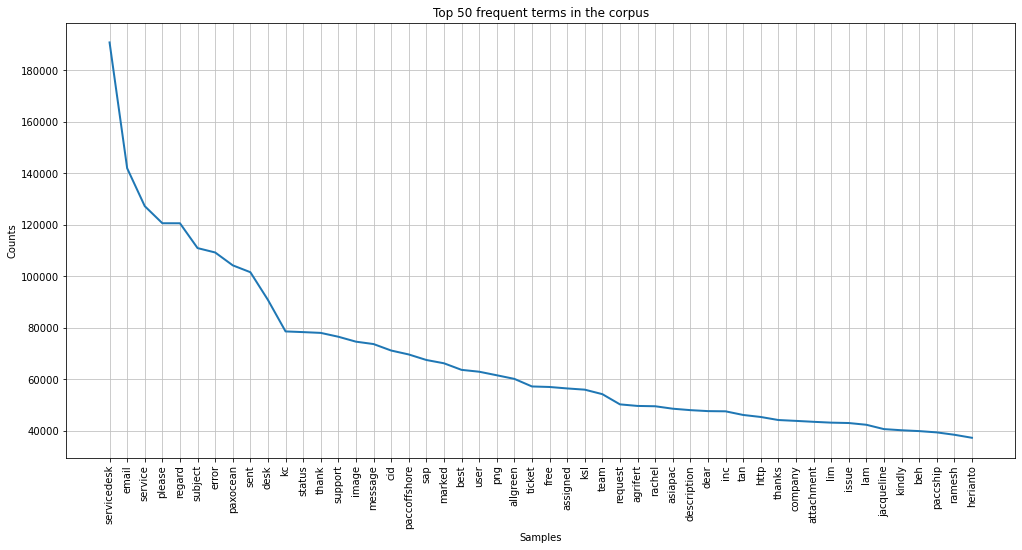

In [55]:
plt.figure(figsize=(17, 8))
plt.title("Top 50 frequent terms in the corpus")
fdist.plot(50)
plt.show()

### Gensim Thematic Analysis
#### Create dictionary and corpus, themes in LDA model

In [56]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

clean_text = Text.tolist()
data_words = list(sent_to_words(clean_text))

print(data_words[:1])

[['software', 'request', 'oneplace', 'solution', 'apps', 'joseph', 'tan']]


In [57]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['software', 'request', 'oneplace_solution', 'apps', 'joseph', 'tan']


In [58]:
# spacy for lemmatization
import spacy
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [59]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [60]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [61]:
print(data_lemmatized[:1])

[['software', 'request', 'app']]


In [62]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [63]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('app', 1), ('request', 1), ('software', 1)]]

In [64]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [65]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"error" + 0.022*"image" + 0.022*"send" + 0.021*"message" + '
  '0.021*"free" + 0.019*"cid" + 0.019*"email" + 0.019*"png" + 0.016*"regard" + '
  '0.015*"company"'),
 (1,
  '0.030*"email" + 0.027*"thank" + 0.024*"good" + 0.022*"ticket" + '
  '0.022*"servicedesk" + 0.020*"regard" + 0.020*"support" + 0.018*"user" + '
  '0.015*"team" + 0.014*"automatically"'),
 (2,
  '0.129*"status" + 0.126*"mark" + 0.099*"assign" + 0.059*"reason" + '
  '0.048*"application" + 0.045*"remedy" + 0.045*"service" + 0.043*"progress" + '
  '0.038*"action" + 0.027*"require"')]


In [66]:
# set a number of k topics to test
list_of_n_topics = list(range(1,10))

list_of_coherence = {}
for i in list_of_n_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    # calculate the coherency
    cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    
    # store the coherencies correspending to each k topic value
    list_of_coherence[str(i)] = cm.get_coherence()

In [67]:
sorted_cohrenec_LDA = sorted(list_of_coherence.items(), key=operator.itemgetter(1))

In [68]:
sorted_cohrenec_LDA

[('9', -3.233204664717096),
 ('8', -2.9158229333163983),
 ('7', -2.8638557101432522),
 ('2', -2.7445934225150066),
 ('6', -2.676588938443148),
 ('5', -2.5480199012056275),
 ('3', -2.362813177280328),
 ('4', -2.2087497673229812),
 ('1', -1.4714312974665387)]

As we can see from the dict above, the more reasonable value for the number of topics is 4

In [69]:
# Build LDA model
best_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [70]:
# Assigns the topics to the documents in corpus
def assign_topic_to_doc(document):
    bow = id2word.doc2bow(document.split())
    t = best_lda_model.get_document_topics(bow)
    # get the topic with highest probability
    topic = max(t, key=itemgetter(1))[0]
    return f"theme_{topic + 1}"


In [71]:
themes = Text.apply(assign_topic_to_doc)

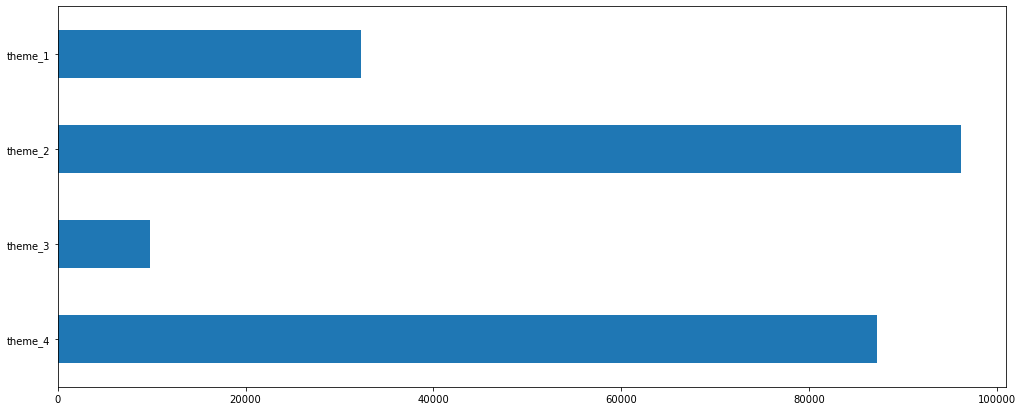

In [72]:
themes.value_counts().sort_index(ascending=False).plot(kind='barh')
plt.show()

The exact labels of the themes remains non-trivial to this analysis it require further analysis  we can plot the WordCloud for each to have an idea of it

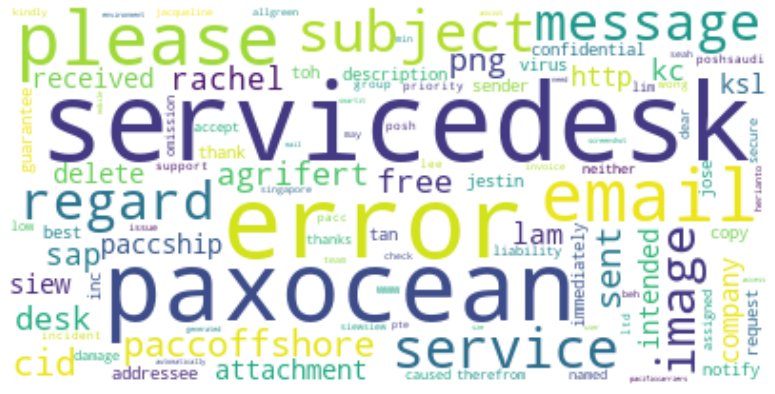

In [73]:
import warnings
warnings.filterwarnings("ignore")
makeImage(getFrequencyDictForText(' '.join(Text[themes == 'theme_1'].tolist())))

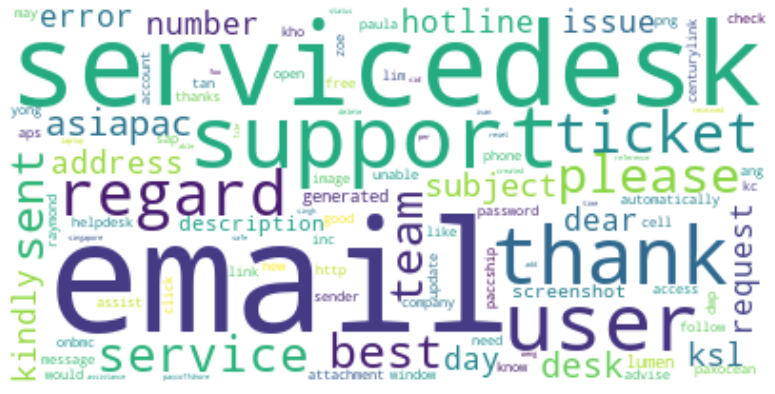

In [74]:
makeImage(getFrequencyDictForText(' '.join(Text[themes == 'theme_2'].tolist())))

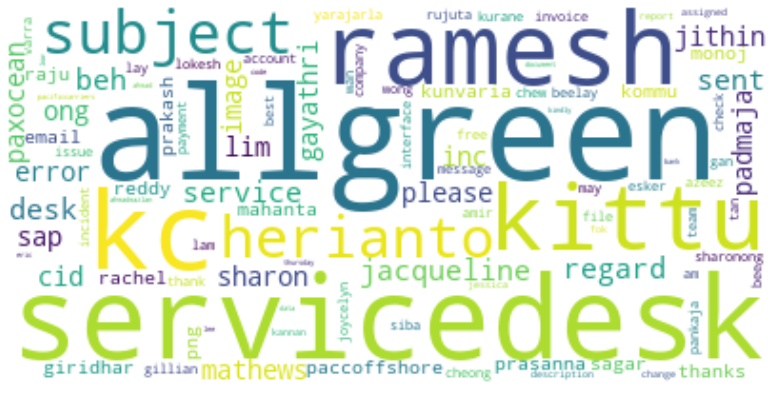

In [75]:
makeImage(getFrequencyDictForText(' '.join(Text[themes == 'theme_3'].tolist())))

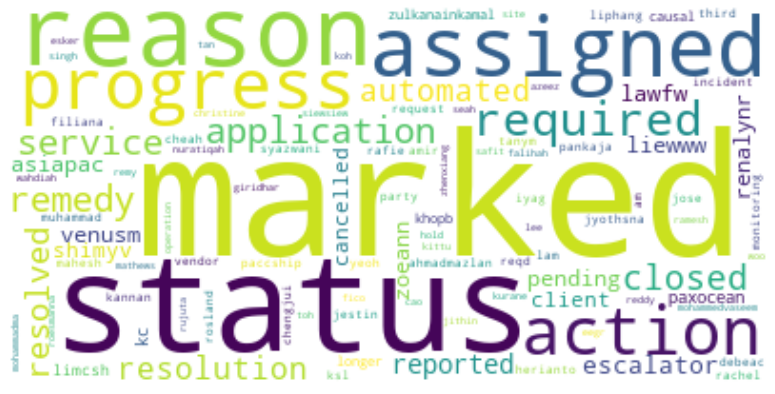

In [76]:
makeImage(getFrequencyDictForText(' '.join(Text[themes == 'theme_4'].tolist())))

**Conclusion**

With this results we can say that we don’t have to rely on the classic metrics anymore and use customer feedback to enhance business growth as it provides more a detailed about the customer’s satisfaction.